In [3]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text
from sklearn.compose import make_column_transformer, make_column_selector
import re
import nltk
import eli5

import spacy
from nltk.chunk.regexp import RegexpParser
from nltk.chunk import tree2conlltags
from nltk import word_tokenize
from itertools import groupby

from sklearn.base import BaseEstimator, TransformerMixin


# setting pandas settings to display additional rows within Jupyter Labs
pd.set_option('display.max_rows', 500)

In [100]:
# importing clean lyric CSV 
lyric_df = pd.read_csv('../data/lyrics_final.csv')

In [101]:
# adding a category_id column to encode decades
lyric_df['category_id'] = lyric_df['decade'].factorize()[0]

In [102]:
lyric_df = lyric_df[(lyric_df['decade'] != 1940) & (lyric_df['decade'] != 1950) & (lyric_df['decade'] != 2010)]

In [104]:
lyric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4395
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     4396 non-null   int64  
 1   song_rank      4396 non-null   int64  
 2   artist_name    4396 non-null   object 
 3   song_title     4396 non-null   object 
 4   year           4396 non-null   int64  
 5   lyrics         4396 non-null   object 
 6   decade         4396 non-null   int64  
 7   word_count     4396 non-null   int64  
 8   characters     4396 non-null   int64  
 9   word_length    4396 non-null   float64
 10  clean_lyrics   4396 non-null   object 
 11  profanity      4396 non-null   bool   
 12  suggestive     4396 non-null   int64  
 13  lyric_valence  4396 non-null   float64
 14  is_positive    4396 non-null   int64  
 15  is_negative    4396 non-null   int64  
 16  is_neutral     4396 non-null   int64  
 17  category_id    4396 non-null   int64  
dtypes: bool(

In [103]:
lyric_df.shape

(4396, 18)

In [6]:
# creating X from the cleaned lyrics
X = lyric_df[['clean_lyrics', 'word_count', 'is_negative','suggestive']]
y = lyric_df['category_id']

# train test split with random state
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=48, stratify = y)

## Baseline Model

Baseline accuracy is 21.7%, the equivalent of choosing the most common decade (the 1980s).

In [98]:
lyric_df['decade'].value_counts(normalize = True).head(1)

1980    0.21747
Name: decade, dtype: float64

## Attempt #1 - Naive Bayes

In [12]:
# creating pipe with naive bayes and countvectorizer
ct1 = make_column_transformer(
    (CountVectorizer(stop_words = 'english', max_features = 1000), 'clean_lyrics'),
    remainder='passthrough',
    verbose_feature_names_out = False)

bayes_pipe = make_pipeline(ct1, StandardScaler(with_mean = False), MultinomialNB())

# gridsearching across ngram ranges
params = {'columntransformer__countvectorizer__max_features': [500, 1000, 1500, 2000, 5000], 'multinomialnb__alpha': [.25, .5, .75, 1, 1.25], 'multinomialnb__fit_prior': [True, False]}

# creating gridsearch and fitting to training data
bayes_grid = GridSearchCV(bayes_pipe, params, n_jobs =-1)
bayes_grid.fit(X_train,y_train)

# creating predictions for test data
preds = bayes_grid.predict(X_test)

# accuracy score for test data
bayes_grid.score(X_test, y_test)

In [18]:
# pulling best parameters from gridsearch
bayes_grid.best_params_

{'columntransformer__countvectorizer__max_features': 2000,
 'multinomialnb__alpha': 1.25,
 'multinomialnb__fit_prior': False}

## Attempt 2 - Logistic Regression

In [22]:
# creating pipe with logistic regression and countvectorizer
ct1 = make_column_transformer(
    (CountVectorizer(stop_words = 'english', max_features = 1000), 'clean_lyrics'),
    remainder='passthrough',
    verbose_feature_names_out = False)

logreg_pipe = make_pipeline(ct1, StandardScaler(with_mean = False), LogisticRegression(random_state = 48))

# gridsearching across ngram ranges
params = {'logisticregression__C': [.25, .5, .75, 1], 'logisticregression__max_iter': [20_000]}

# creating gridsearch and fitting to training data
logreg_grid = GridSearchCV(logreg_pipe, params, n_jobs =-1)
logreg_grid.fit(X_train,y_train)

# creating predictions from training data
preds = logreg_grid.predict(X_test)

# accuracy score on test set
logreg_grid.score(X_test, y_test)

In [27]:
# pulling best parameters from gridsearch
logreg_grid.best_params_

{'logisticregression__C': 0.25, 'logisticregression__max_iter': 20000}

### Logistic Regression Coefficients

In [49]:
weights = eli5.show_weights(estimator = logreg_grid.best_estimator_.named_steps['logisticregression'], 
                            feature_names = logreg_grid.best_estimator_.named_steps['columntransformer'].get_feature_names_out(), 
                            top=15,
                            target_names = {0: '1960s', 1: '1970s', 2: '1980s', 3: '1990s', 4: '2000s'})
weights.data = weights.data.replace('background-color:', 'color:black; background-color:')
weights

## Attempt 3 - Gradient Boosting Classifier

In [52]:
# creating pipe with naive bayes and countvectorizer
ct1 = make_column_transformer(
    (CountVectorizer(stop_words = 'english', max_features = 5000), 'clean_lyrics'),
    remainder='passthrough',
    verbose_feature_names_out = False)

boost_pipe = make_pipeline(ct1, StandardScaler(with_mean = False), GradientBoostingClassifier(random_state = 48))

# gridsearching across ngram ranges
params = {'gradientboostingclassifier__n_estimators': [50, 100, 200], 'gradientboostingclassifier__max_depth': [2,3,4,5]}

# creating gridsearch and fitting to training data
boost_grid = GridSearchCV(boost_pipe, params, n_jobs =-1)
boost_grid.fit(X_train,y_train)

# creating predictions from training data
preds = boost_grid.predict(X_test)

# accuracy score on test set
boost_grid.score(X_test, y_test)

In [57]:
boost_grid.best_params_

{'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 200}

### Gradient Boosting Weights

In [58]:
weights = eli5.show_weights(estimator = boost_grid.best_estimator_.named_steps['gradientboostingclassifier'], 
                            feature_names = boost_grid.best_estimator_.named_steps['columntransformer'].get_feature_names_out(), 
                            top=25,
                            target_names = {0: '1940s', 1: '1950s', 2: '1960s', 3: '1970s', 4: '1980s', 5: '1990s', 6: '2000s', 7: '2010s'})
weights.data = weights.data.replace('background-color:', 'color:black; background-color:')
weights

Weight,Feature
0.2387 ± 0.2931,word_count
0.0142 ± 0.0473,gon
0.0097 ± 0.0717,know
0.0085 ± 0.0413,club
0.0084 ± 0.0487,girl
0.0084 ± 0.0722,like
0.0079 ± 0.0656,suggestive
0.0074 ± 0.0555,feel
0.0061 ± 0.0727,tonight
0.0060 ± 0.0474,tryna


### Analyzing Predictions

In [44]:
# creating a new dataframe from the test data with predictions
X_test['predictions'] = boost_grid.predict(X_test)
X_test['category_id'] = y_test
lyric_df = X_test.join(lyric_df, how = 'left', lsuffix = 'old')

# creating an accuracy column to indicate whether the prediction was correct
lyric_df['accurate'] = np.where(lyric_df['predictions'] == lyric_df['category_id'], 1, 0)

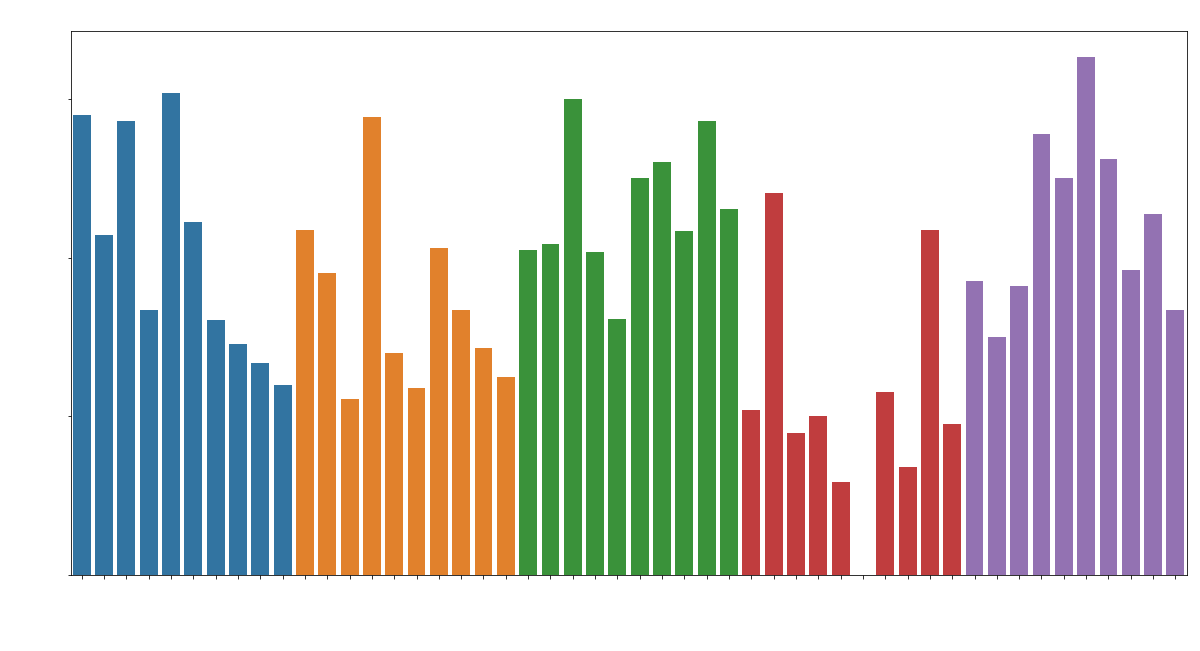

In [51]:
pred_plot = lyric_df.groupby('year')[['accurate', 'decade']].mean().reset_index()


plt.figure(figsize = (20, 10))
plt.title("Accuracy Drops As Songs Near the Turn of a Decade", size = 25, color = 'white')
plt.xticks(rotation = 50, size = 15, color = 'white')
plt.yticks(ticks = [0, .2, .4, .6, .8, 1], labels = ['0%', '20%', '40%', '60%', '80%', '100%'], size = 15, color = 'white')
sns.barplot(data = pred_plot, x = 'year', y = 'accurate', hue = 'decade', dodge = False)
plt.xlabel('Year', size = 20, color = 'white')
plt.ylabel('Average Accuracy', size = 20, color = 'white')
plt.legend([], [], frameon = False)
plt.savefig('../assets/yearly_accuracy.png', transparent=True);

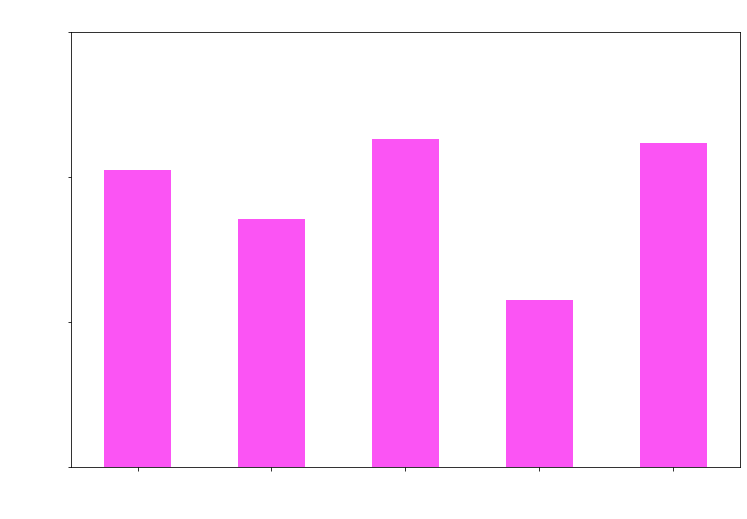

In [63]:
lyric_df.groupby('decade')['accurate'].mean().plot(kind = 'bar', figsize = (12,8), color = '#fb54f4')

plt.title('Performance Varies Greatly Each Decade', size = 25, color = 'white')
plt.ylabel('Average Accuracy', size = 20, color = 'white')
plt.xlabel('Decade', size = 20, color = 'white')
plt.yticks(ticks = [0, .2, .4, .6], labels = ['0%', '20%', '40%', '60%'], size = 15, color = 'white')
plt.xticks(rotation = .25, size = 15, color = 'white')
plt.savefig('../assets/decade_accuracy.png', transparent=True);

In [68]:
lyric_df.head(2)

,clean_lyricsold,word_countold,is_negativeold,suggestiveold,predictionsold,category_idold,clean_lyricsold,word_countold,is_negativeold,suggestiveold,...,clean_lyrics,profanity,suggestive,lyric_valence,is_positive,is_negative,is_neutral,category_id,predictions,accurate
1895,doo ooh ooh doo wee ooh always together togeth...,320,0,0,2,2,doo ooh ooh doo wee ooh always together togeth...,320,0,0,...,doo ooh ooh doo wee ooh always together togeth...,False,0,0.9988,1,0,0,2,0,0
1028,really love tell really love tell really love ...,232,0,0,1,1,really love tell really love tell really love ...,232,0,0,...,really love tell really love tell really love ...,False,0,0.9965,1,0,0,1,3,0


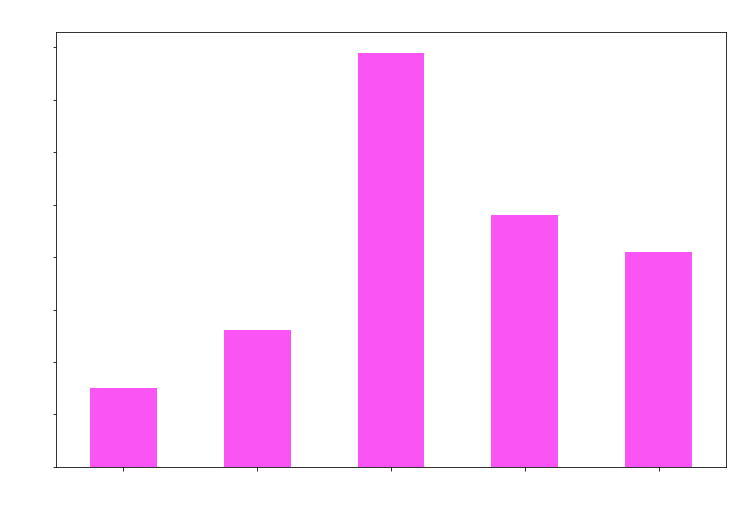

In [90]:
lyric_df[lyric_df['decade'] == 1990].groupby('predictions')['predictions'].count().plot(kind = 'bar', figsize = (12,8), color = '#fb54f4')

plt.title('90s Songs Are Mistaken for the 80s', size = 25, color = 'white')
plt.ylabel('Prediction Count', size = 20, color = 'white')
plt.xlabel('Predicted Decade', size = 20, color = 'white')
plt.xticks(rotation = 0, ticks = [0, 1, 2, 3, 4], labels = ['1960s', '1970s', '1980s', '1990s', '2000s'], size = 15, color = 'white')
plt.yticks(size = 15, color = 'white')
plt.savefig('../assets/1990s.png', transparent=True);

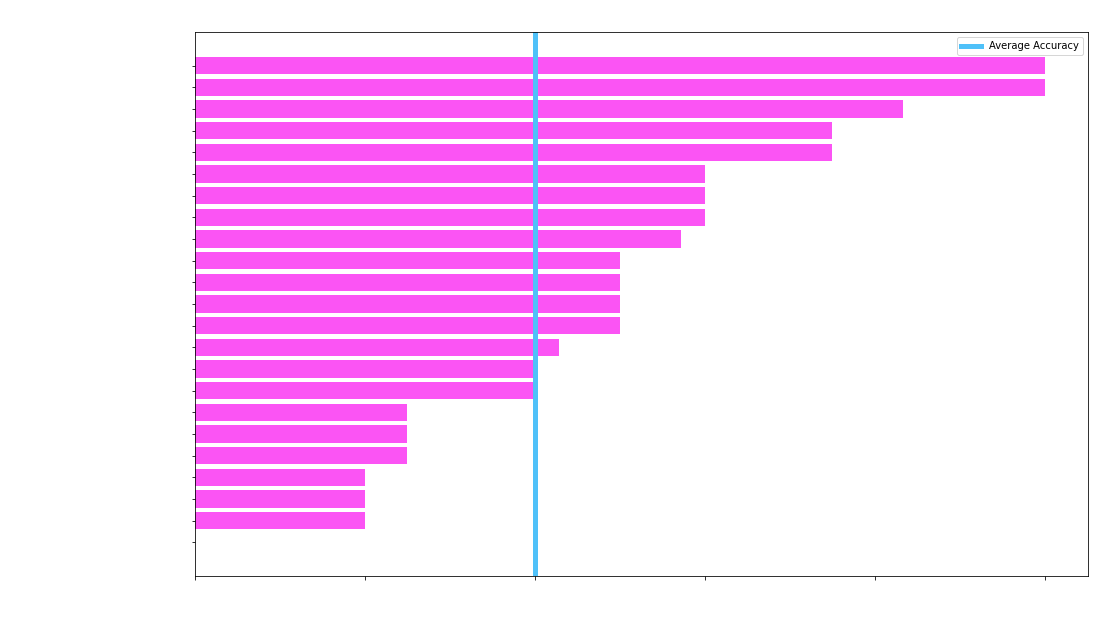

In [62]:
artist_preds = lyric_df.groupby('artist_name').agg(count=('artist_name', 'size'), accuracy=('accurate', 'mean')).reset_index().sort_values(by = 'count', ascending = False)

artist_preds = artist_preds[artist_preds['count'] > 3]

artist_preds.shape

plt.figure(figsize = (16,10))
plt.barh(data = artist_preds.sort_values(by = 'accuracy', ascending = True), y = 'artist_name', width = 'accuracy', color = '#fb54f4')

plt.title('More Popular Artists Outperform the Average', size = 25, color = 'white')
plt.xlabel('Accuracy %', size = 20, color = 'white')
plt.xticks(ticks = [0, .2, .4, .6, .8, 1], labels = ['0%', '20%', '40%', '60%', '80%', '100%'], size = 15, color = 'white')
plt.yticks(size = 14, color = 'white')
plt.axvline(x=.4, color='#4fc1f9', linewidth = 5, linestyle='-', label = 'Average Accuracy'), 
plt.legend()
plt.savefig('../assets/artist_accuracy.png', transparent=True);
